# Final feature set

Note: On the original run a mistake was made in the data preparation stage which caused the MSE to be artificially low. This was because we added all possible gameweeks for every player where some players would only play a single season in the PL. This lead to the creation of too many 0 targets which are easy to predict and lowered the MSE.

## Set-up

In [1]:
import os
import getpass
import pickle

import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
from s3fs import S3FileSystem
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model, Model
from keras.layers import Dense, Flatten, LSTM, BatchNormalization, Input, Dropout, Activation, Bidirectional
from keras import initializers, optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
os.chdir('../..')

In [3]:
from src.models.utils import \
    _load_all_historical_data, \
    _map_season_string_to_ordered_numeric, \
    _generate_known_features_for_next_gw, \
    custom_train_test_split, \
    split_sequences
from src.visualisation.utils import plot_learning_curve

In [4]:
pd.options.display.max_columns = None

In [5]:
RANDOM_SEED = 3
N_STEPS_IN = 5
N_STEPS_OUT = 5

In [6]:
AWS_ACCESS_KEY_ID = getpass.getpass()
AWS_SECRET_KEY = getpass.getpass()

 ····················
 ········································


In [7]:
s3_filesystem = S3FileSystem(
    key=AWS_ACCESS_KEY_ID,
    secret=AWS_SECRET_KEY
)

## 1. Load results of PFI feature selection

In [8]:
with open('data/processed/pfi_feature_selection_results.pickle', 'rb') as file:  
    pfi_feature_selection_df = pickle.load(file)

In [9]:
pfi_feature_selection_df.head()

,features,model,dev_error,features_to_drop
ROUND_1,"[gw, Aerial Duels - Won - Percentage, Aerial D...",<keras.engine.training.Model object at 0x7feae...,4.56021,"[Launches, Shots - Six Yard Box, Touches - Opp..."
ROUND_2,"[Goals From Indirect Free-kick, Passes - Own H...",<keras.engine.training.Model object at 0x7feae...,4.55647,"[xA Set Play, Headed Goal Attempts - On Target..."
ROUND_3,"[Goals From Indirect Free-kick, Passes - Own H...",<keras.engine.training.Model object at 0x7fead...,4.53751,"[Touches - Own Half, Passes Received, Clearanc..."
ROUND_4,"[Goals From Indirect Free-kick, Passes - Own H...",<keras.engine.training.Model object at 0x7fead...,4.53993,"[Passes - Opponents Half - Right - Successful,..."
ROUND_5,"[Goals From Indirect Free-kick, Passes - Own H...",<keras.engine.training.Model object at 0x7fead...,4.53181,"[Chances Missed, Touches - Opponents Half, Sho..."


In [10]:
pfi_feature_selection_df['num_features'] = pfi_feature_selection_df['features'].apply(len)
pfi_feature_selection_df['num_features_dropped'] = pfi_feature_selection_df['features_to_drop'].apply(len)

In [11]:
pfi_feature_selection_df

,features,model,dev_error,features_to_drop,num_features,num_features_dropped
ROUND_1,"[gw, Aerial Duels - Won - Percentage, Aerial D...",<keras.engine.training.Model object at 0x7feae...,4.56021,"[Launches, Shots - Six Yard Box, Touches - Opp...",279,28
ROUND_2,"[Goals From Indirect Free-kick, Passes - Own H...",<keras.engine.training.Model object at 0x7feae...,4.55647,"[xA Set Play, Headed Goal Attempts - On Target...",251,25
ROUND_3,"[Goals From Indirect Free-kick, Passes - Own H...",<keras.engine.training.Model object at 0x7fead...,4.53751,"[Touches - Own Half, Passes Received, Clearanc...",226,23
ROUND_4,"[Goals From Indirect Free-kick, Passes - Own H...",<keras.engine.training.Model object at 0x7fead...,4.53993,"[Passes - Opponents Half - Right - Successful,...",203,21
ROUND_5,"[Goals From Indirect Free-kick, Passes - Own H...",<keras.engine.training.Model object at 0x7fead...,4.53181,"[Chances Missed, Touches - Opponents Half, Sho...",182,19
ROUND_6,"[Goals From Indirect Free-kick, Passes - Own H...",<keras.engine.training.Model object at 0x7fead...,4.52377,"[Saves With Feet, Sky Bonus Total, Duels Lost,...",163,17
ROUND_7,"[Passes - Own Half - Unsuccessful, Flick Ons, ...",<keras.engine.training.Model object at 0x7fead...,4.51735,"[Duels Won, Goals From Throw-in, ICT Threat, C...",146,15
ROUND_8,"[Passes - Own Half - Unsuccessful, Flick Ons, ...",<keras.engine.training.Model object at 0x7fead...,4.49424,"[Flick Ons, Long Clearances, Sky Minutes Per B...",131,13
ROUND_9,"[Goal Kicks, Headed Goals, number_of_home_matc...",<keras.engine.training.Model object at 0x7fead...,4.52332,"[Passes - Long - Successful, Premier League Ye...",118,12
ROUND_10,"[Goal Kicks, Aerial Duels - Won - Percentage, ...",<keras.engine.training.Model object at 0x7fead...,4.52831,"[Blocks, Aerial Duels Lost, Sky Bonus Saves Ti...",106,11


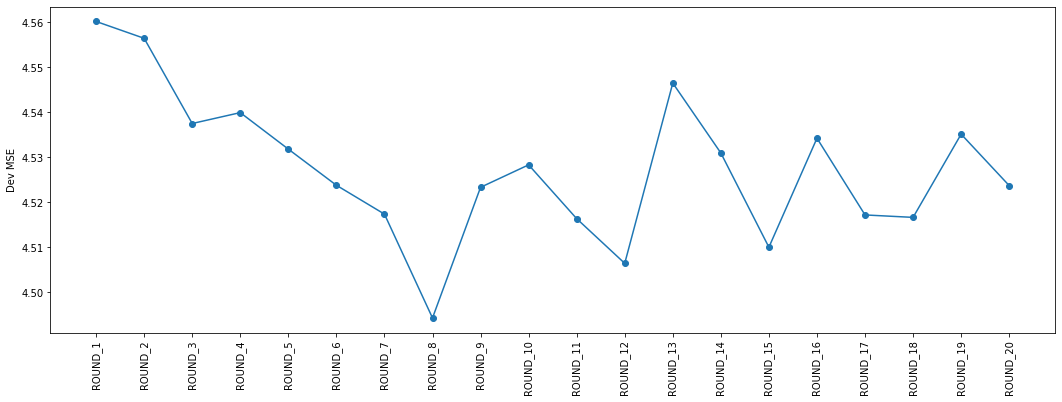

In [12]:
plt.figure(figsize=(18, 6))
plt.plot(pfi_feature_selection_df.index, pfi_feature_selection_df['dev_error'], '-o')
plt.xticks(rotation=90)
plt.ylabel('Dev MSE')
plt.show()

In [13]:
pfi_feature_selection_df.loc['ROUND_8']['num_features']

131

In [14]:
pfi_feature_selection_df.loc['ROUND_15']['num_features']

61

Use round 15 features

In [15]:
set(pfi_feature_selection_df.loc['ROUND_15']['features'])

{'Aerial Duels - Won - Percentage',
 'Bad Touches',
 'Big Chances Created',
 'Caught Offside',
 'Chances From Counter Attack',
 'Clean Sheets',
 'Crosses - Open Play - Successful',
 'Crosses - Unsuccessful',
 'Distribution - Successful',
 'Dribbles - Successful Percentage',
 'Fouls',
 'Goals Conceded',
 'Handballs',
 'ICT Creativity',
 'ICT Index',
 'Minutes Per Block',
 'Minutes Per Interception',
 'Minutes Per Save',
 'Minutes Per Tackle Won',
 'Minutes Per Touch',
 'Minutes Per xG',
 'Pass Completion',
 'Pass Completion - Final Third',
 'Pass Completion - Opponents Half',
 'Passes - Backward',
 'Passes - Forward',
 'Premier League Straight Red Cards',
 'Premier League Total Red Cards',
 'Recoveries',
 'Saves (Shots Outside Box)',
 'Shot Accuracy',
 'Shots Blocked',
 'Sky Bonus Passes Tier 1',
 'Sky Bonus Passes Tier 2',
 'Sky Bonus Shots Tier 1',
 'Subbed Off',
 'Subbed On',
 'Tackles - Won - Percentage',
 'Tackles Lost',
 'Take Ons',
 'Take Ons - Successful Percentage',
 'Throw Ins

_What is 'Sky Bonus Shots Tier 1'?_

Features which were dropped before this round:

In [16]:
set(pfi_feature_selection_df.loc['ROUND_1']['features']) - set(pfi_feature_selection_df.loc['ROUND_15']['features'])

{'Aerial Duels Lost',
 'Aerial Duels Total',
 'Aerial Duels Won',
 'Assists',
 'Attempts From Crossed Corners',
 'Attempts From Direct Free-kick',
 'Attempts From Indirect Free-kick',
 'Attempts From Set Plays',
 'Attempts from Throw-in',
 'Big Chances Missed',
 'Big Chances Missed Ball',
 'Big Chances Missed Shots',
 'Big Chances Scored',
 'Big Chances Total',
 'Blocks',
 'CBI',
 'Chances Created',
 'Chances Created (Centre Zone)',
 'Chances Created (Left Zone)',
 'Chances Created (Right Zone)',
 'Chances From Open Play',
 'Chances Missed',
 'Clearances',
 'Clearances - Successful',
 'Clearances - Unsuccessful',
 'Corner Conversion',
 'Corners',
 'Corners - Successful',
 'Corners - Unsuccessful',
 'Cross Completion',
 'Crosses',
 'Crosses - Open Play - Unsuccessful',
 'Crosses - Opponents Half (Left Zone)',
 'Crosses - Opponents Half (Right Zone)',
 'Crosses - Successful',
 'Crosses From Open Play',
 'Dispossessed',
 'Distribution - Kicks From Hands',
 'Distribution - Throws',
 'Distr

We will add the following features:
- Assists
- Goals

In [17]:
FEATURES_TO_ADD = ['Assists', 'Goals']

## 2. Preprocessing

### Load FFS data

In [18]:
ffs_all_data_1719 = pq.read_table(
    f"s3://fantasy-football-scout/processed/fantasy_football_scout_all_features_1718_to_1819.parquet", 
    filesystem=s3_filesystem
).to_pandas()

print(ffs_all_data_1719.shape)
ffs_all_data_1719.head()

(20449, 308)


,Name,Team,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Appearances,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,position,full_name,season,gw,Attempts From Set Plays Conceded,Attempts from Throw-in,BPS Baseline,BPS CBI,BPS Clean Sheets,BPS Goals,BPS Pass Completion,BPS Recoveries,BPS Time Played,BPS Yellow Cards,Bad Touches,Big Chances Conceded,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,Bonus Points,CBI,Caught Offside,Chances Conceded (Centre Zone),Chances Conceded (Left Zone),Chances Conceded (Right Zone),Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Percentage Centre Zone),Chances Created (Percentage Left Zone),Chances Created (Percentage Right Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Percentage Left Zone),Crosses - Opponents Half (Percentage Right Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses Conceded (Left Zone),Crosses Conceded (Right Zone),Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,Exact Time Played,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Games Played,Goal Attempts,Goal Attempts Conceded,Goal Attempts In Box Conceded,Goal Attempts Outside Box Conceded,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goal Attempts Conceded,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Baseline BPS,Minutes Per Big Chance,Minutes Per Big Chance Conceded,Minutes Per Block,Minutes Per Chance,Minutes Per Chance Conceded,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xG Conceded,Minutes Per xG On Target Conceded,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Open Play Goal Attempts,Open Play Goal Attempts Conceded,Overall Points,Own Goals,Ownership,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - 

In [19]:
ffs_all_data_1719.drop(columns=['Name', 'full_name'], inplace=True)

### Deal with nulls and inf values

In [20]:
columns_with_inf = []
for col in ffs_all_data_1719.columns:
    if np.inf in ffs_all_data_1719[col].values:
        print(col)
        print(ffs_all_data_1719[ffs_all_data_1719['Minutes Per xA'] == np.inf].shape[0] / ffs_all_data_1719.shape[0])
        columns_with_inf.append(col)
        print('\n')

Minutes Per xA
0.30275319086507896


Minutes Per xG
0.30275319086507896


Minutes Per xGI
0.30275319086507896


Minutes Per xGP
0.30275319086507896


Sky Minutes Per Bonus
0.30275319086507896




Looks like `inf` caused by divide by zero error. For now let's impute with 0 but if these features are shown to be predictive then may need to revisit this. Could use a very large number instead.

In [21]:
for col in columns_with_inf:
    ffs_all_data_1719[col].replace({np.inf: 0}, inplace=True)

nan

In [22]:
ffs_all_data_1719.replace({'nan': np.nan}, inplace=True)

### Drop features with all nulls

In [23]:
ffs_all_data_1719.dropna(axis=1, how='all', inplace=True)

### Add 0 minute events back into data

FFS data only includes players who played > 0 minutes. Therefore if a player is benched one gameweek then they wouldn't appear in the data although we would like to train our model on these cases.

We therefore create a 'master' DataFrame of all unique names and all possible season and gameweek combinations. We then left join the FFS data and fill in nulls with zeros.

In [24]:
ffs_all_data_1719['season'].unique()

array(['2017-2018', '2018-2019'], dtype=object)

In [25]:
ffs_data_names = ffs_all_data_1719[['name', 'Team', 'position', 'season']].drop_duplicates()
ffs_data_names['key'] = 1
ffs_data_names.shape

(1020, 5)

In [26]:
gw_df = pd.DataFrame({'gw': range(1, 39)})
gw_df['key'] = 1
gw_df.head()

,gw,key
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [27]:
all_player_season_gw_df = gw_df.merge(ffs_data_names, on='key')
all_player_season_gw_df.drop('key', axis=1, inplace=True)
all_player_season_gw_df.shape

(38760, 5)

In [28]:
all_player_season_gw_df.head()

,gw,name,Team,position,season
0,1,gabriel_fernando de jesus,MCI,FWD,2017-2018
1,1,danny_welbeck,ARS,FWD,2017-2018
2,1,sam_vokes,BUR,FWD,2017-2018
3,1,jamie_vardy,LEI,FWD,2017-2018
4,1,diafra_sakho,WHU,FWD,2017-2018


In [29]:
ffs_data = all_player_season_gw_df.merge(ffs_all_data_1719, on=['name', 'Team', 'position', 'gw', 'season'], how='left')
print(ffs_data.shape)
ffs_data.head()

(38760, 278)


,gw,name,Team,position,season,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Appearances,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,Attempts from Throw-in,BPS Baseline,BPS CBI,BPS Clean Sheets,BPS Goals,BPS Pass Completion,BPS Recoveries,BPS Time Played,BPS Yellow Cards,Bad Touches,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,Bonus Points,CBI,Caught Offside,Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,Exact Time Played,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Goal Attempts,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Baseline BPS,Minutes Per Block,Minutes Per Chance,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Overall Points,Own Goals,Ownership,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - Centre - Successful,Passes - Opponents Half - Centre - Unsuccessful,Passes - Opponents Half - Left - Successful,Passes - Opponents Half - Left - Unsuccessful,Passes - Opponents Half - Right - Successful,Passes - Opponents Half - Right - Unsuccessful,Passes - Opponents Half - Successful,Passes - Opponents Half - Unsuccessful,Passes - Own Half,Passes - Own Half - Unsuccessful,Passes - Square,Passes - Successful,Passes - Successful - Own Half,Passes - Unsuccessful,Passes Received,Passes Received - Final Third,Passes Received - Opponents Half,Passes Received - Opponents Half (Centre),Passes Received - Opponents Half (Left),Passes Received - Opponents Half (Right),Passes Received - Own Half,Passing - Through Balls,Penalties Conceded,Penalties Faced,Penal

In [30]:
ffs_data.sort_values(['name', 'season', 'gw'], inplace=True)
ffs_data.head()

,gw,name,Team,position,season,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Appearances,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,Attempts from Throw-in,BPS Baseline,BPS CBI,BPS Clean Sheets,BPS Goals,BPS Pass Completion,BPS Recoveries,BPS Time Played,BPS Yellow Cards,Bad Touches,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,Bonus Points,CBI,Caught Offside,Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,Exact Time Played,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Goal Attempts,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Baseline BPS,Minutes Per Block,Minutes Per Chance,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Overall Points,Own Goals,Ownership,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - Centre - Successful,Passes - Opponents Half - Centre - Unsuccessful,Passes - Opponents Half - Left - Successful,Passes - Opponents Half - Left - Unsuccessful,Passes - Opponents Half - Right - Successful,Passes - Opponents Half - Right - Unsuccessful,Passes - Opponents Half - Successful,Passes - Opponents Half - Unsuccessful,Passes - Own Half,Passes - Own Half - Unsuccessful,Passes - Square,Passes - Successful,Passes - Successful - Own Half,Passes - Unsuccessful,Passes Received,Passes Received - Final Third,Passes Received - Opponents Half,Passes Received - Opponents Half (Centre),Passes Received - Opponents Half (Left),Passes Received - Opponents Half (Right),Passes Received - Own Half,Passing - Through Balls,Penalties Conceded,Penalties Faced,Penal

In [31]:
ffs_data.isnull().sum()

gw                                       0
name                                     0
Team                                     0
position                                 0
season                                   0
                                     ...  
xG Prevented                         18311
xG Set Play                          18311
xGI Delta (Goals + Assists - xGI)    18311
xGI Expected Goal Involvement        18311
total_points                         18311
Length: 278, dtype: int64

In [32]:
# From an offline check the missing entries are 0 minutes players in a given GW. We can therefore fill all missing data points with 0.
ffs_data.fillna(0, inplace=True)

### Position dummies

In [33]:
ffs_data = pd.get_dummies(ffs_data, columns=['position'])

In [34]:
ffs_data.rename(columns={'Team': 'team_name'}, inplace=True)

### Merge fixture and odds data

Merging fixture data also serves another purpose. In the previous step we created _all_ possible gameweek-player combinations. However, due to double gameweeks there are many cases where a player simply would not feature in a given gameweek and in this case we want to remove that player-gameweek for the data. An inner join to fixtures data does this.

In [35]:
fixture_and_odds_features = pd.read_parquet('data/processed/formatted_fixture_and_odds_features_2016_to_2019.parquet')
print(fixture_and_odds_features.shape)
fixture_and_odds_features.head()

(2193, 19)


,season,gw,team_name,draw_odds,win_odds,lose_odds,number_of_home_matches,number_of_promoted_side_opponent,number_of_top_6_last_season_opponent,promoted_side,top_6_last_season,double_gameweek,next_gameweek_draw_odds,next_gameweek_win_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_double_gameweek
0,2016-17,1,Arsenal,2.34,1.73,1.72,1.0,0,0,0,1,0,2.51,1.58,1.79,0.0,0.0,1.0,0.0
1,2016-17,2,Arsenal,2.51,1.58,1.79,0.0,0,1,0,1,0,3.00,0.64,4.82,0.0,0.0,0.0,0.0
2,2016-17,3,Arsenal,3.00,0.64,4.82,0.0,0,0,0,1,0,3.00,0.61,5.18,1.0,0.0,1.0,0.0
3,2016-17,4,Arsenal,3.00,0.61,5.18,1.0,0,1,0,1,0,3.08,0.62,4.99,0.0,1.0,0.0,0.0
4,2016-17,5,Arsenal,3.08,0.62,4.99,0.0,1,0,0,1,0,2.43,1.42,2.07,1.0,0.0,0.0,0.0


### Format FFS team names and seasons to match

In [36]:
ffs_data.head()

,gw,name,team_name,season,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Appearances,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,Attempts from Throw-in,BPS Baseline,BPS CBI,BPS Clean Sheets,BPS Goals,BPS Pass Completion,BPS Recoveries,BPS Time Played,BPS Yellow Cards,Bad Touches,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,Bonus Points,CBI,Caught Offside,Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,Exact Time Played,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Goal Attempts,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Baseline BPS,Minutes Per Block,Minutes Per Chance,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Overall Points,Own Goals,Ownership,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - Centre - Successful,Passes - Opponents Half - Centre - Unsuccessful,Passes - Opponents Half - Left - Successful,Passes - Opponents Half - Left - Unsuccessful,Passes - Opponents Half - Right - Successful,Passes - Opponents Half - Right - Unsuccessful,Passes - Opponents Half - Successful,Passes - Opponents Half - Unsuccessful,Passes - Own Half,Passes - Own Half - Unsuccessful,Passes - Square,Passes - Successful,Passes - Successful - Own Half,Passes - Unsuccessful,Passes Received,Passes Received - Final Third,Passes Received - Opponents Half,Passes Received - Opponents Half (Centre),Passes Received - Opponents Half (Left),Passes Received - Opponents Half (Right),Passes Received - Own Half,Passing - Through Balls,Penalties Conceded,Penalties Faced,Penalties

In [37]:
ffs_data['season'].replace({'2017-2018': '2017-18', '2018-2019': '2018-19'}, inplace=True)

In [38]:
ffs_team_name_to_fpl = {
    'WHU': 'West Ham United', 
    'BUR': 'Burnley', 
    'HUD': 'Huddersfield Town', 
    'ARS': 'Arsenal', 
    'CRY': 'Crystal Palace', 
    'WAT': 'Watford', 
    'FUL': 'Fulham', 
    'LIV': 'Liverpool', 
    'BOU': 'Bournemouth',
    'WOL': 'Wolverhampton Wanderers', 
    'EVE': 'Everton', 
    'LEI': 'Leicester City', 
    'WBA': 'West Bromwich Albion', 
    'NEW': 'Newcastle United', 
    'SOU': 'Southampton', 
    'MUN': 'Manchester United', 
    'SWA': 'Swansea City', 
    'BHA': 'Brighton & Hove Albion',
    'CHE': 'Chelsea',
    'CAR': 'Cardiff City',
    'MCI': 'Manchester City',
    'TOT': 'Tottenham Hotspur',
    'STK': 'Stoke City'
}

In [39]:
ffs_data['team_name'].replace(ffs_team_name_to_fpl, inplace=True)

In [40]:
ffs_data.head()

,gw,name,team_name,season,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Appearances,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,Attempts from Throw-in,BPS Baseline,BPS CBI,BPS Clean Sheets,BPS Goals,BPS Pass Completion,BPS Recoveries,BPS Time Played,BPS Yellow Cards,Bad Touches,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,Bonus Points,CBI,Caught Offside,Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,Exact Time Played,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Goal Attempts,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Baseline BPS,Minutes Per Block,Minutes Per Chance,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Overall Points,Own Goals,Ownership,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - Centre - Successful,Passes - Opponents Half - Centre - Unsuccessful,Passes - Opponents Half - Left - Successful,Passes - Opponents Half - Left - Unsuccessful,Passes - Opponents Half - Right - Successful,Passes - Opponents Half - Right - Unsuccessful,Passes - Opponents Half - Successful,Passes - Opponents Half - Unsuccessful,Passes - Own Half,Passes - Own Half - Unsuccessful,Passes - Square,Passes - Successful,Passes - Successful - Own Half,Passes - Unsuccessful,Passes Received,Passes Received - Final Third,Passes Received - Opponents Half,Passes Received - Opponents Half (Centre),Passes Received - Opponents Half (Left),Passes Received - Opponents Half (Right),Passes Received - Own Half,Passing - Through Balls,Penalties Conceded,Penalties Faced,Penalties

In [41]:
ffs_data.shape

(38760, 281)

### Combine feature and odds features

In [42]:
fixture_and_odds_features.head()

,season,gw,team_name,draw_odds,win_odds,lose_odds,number_of_home_matches,number_of_promoted_side_opponent,number_of_top_6_last_season_opponent,promoted_side,top_6_last_season,double_gameweek,next_gameweek_draw_odds,next_gameweek_win_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_double_gameweek
0,2016-17,1,Arsenal,2.34,1.73,1.72,1.0,0,0,0,1,0,2.51,1.58,1.79,0.0,0.0,1.0,0.0
1,2016-17,2,Arsenal,2.51,1.58,1.79,0.0,0,1,0,1,0,3.00,0.64,4.82,0.0,0.0,0.0,0.0
2,2016-17,3,Arsenal,3.00,0.64,4.82,0.0,0,0,0,1,0,3.00,0.61,5.18,1.0,0.0,1.0,0.0
3,2016-17,4,Arsenal,3.00,0.61,5.18,1.0,0,1,0,1,0,3.08,0.62,4.99,0.0,1.0,0.0,0.0
4,2016-17,5,Arsenal,3.08,0.62,4.99,0.0,1,0,0,1,0,2.43,1.42,2.07,1.0,0.0,0.0,0.0


In [43]:
ffs_data.head()

,gw,name,team_name,season,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Appearances,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,Attempts from Throw-in,BPS Baseline,BPS CBI,BPS Clean Sheets,BPS Goals,BPS Pass Completion,BPS Recoveries,BPS Time Played,BPS Yellow Cards,Bad Touches,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,Bonus Points,CBI,Caught Offside,Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,Exact Time Played,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Goal Attempts,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Baseline BPS,Minutes Per Block,Minutes Per Chance,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Overall Points,Own Goals,Ownership,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - Centre - Successful,Passes - Opponents Half - Centre - Unsuccessful,Passes - Opponents Half - Left - Successful,Passes - Opponents Half - Left - Unsuccessful,Passes - Opponents Half - Right - Successful,Passes - Opponents Half - Right - Unsuccessful,Passes - Opponents Half - Successful,Passes - Opponents Half - Unsuccessful,Passes - Own Half,Passes - Own Half - Unsuccessful,Passes - Square,Passes - Successful,Passes - Successful - Own Half,Passes - Unsuccessful,Passes Received,Passes Received - Final Third,Passes Received - Opponents Half,Passes Received - Opponents Half (Centre),Passes Received - Opponents Half (Left),Passes Received - Opponents Half (Right),Passes Received - Own Half,Passing - Through Balls,Penalties Conceded,Penalties Faced,Penalties

In [44]:
# Inner join also removes gw-season fixtures which did not happen but were filled with 0s
print(ffs_data.shape)

ffs_data = ffs_data.merge(
    fixture_and_odds_features, 
    on=['season', 'gw', 'team_name'], 
    how='inner'
)

print(ffs_data.shape)

ffs_data.head()

(38760, 281)
(37090, 297)


,gw,name,team_name,season,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Appearances,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,Attempts from Throw-in,BPS Baseline,BPS CBI,BPS Clean Sheets,BPS Goals,BPS Pass Completion,BPS Recoveries,BPS Time Played,BPS Yellow Cards,Bad Touches,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,Bonus Points,CBI,Caught Offside,Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,Exact Time Played,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Goal Attempts,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Baseline BPS,Minutes Per Block,Minutes Per Chance,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Overall Points,Own Goals,Ownership,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - Centre - Successful,Passes - Opponents Half - Centre - Unsuccessful,Passes - Opponents Half - Left - Successful,Passes - Opponents Half - Left - Unsuccessful,Passes - Opponents Half - Right - Successful,Passes - Opponents Half - Right - Unsuccessful,Passes - Opponents Half - Successful,Passes - Opponents Half - Unsuccessful,Passes - Own Half,Passes - Own Half - Unsuccessful,Passes - Square,Passes - Successful,Passes - Successful - Own Half,Passes - Unsuccessful,Passes Received,Passes Received - Final Third,Passes Received - Opponents Half,Passes Received - Opponents Half (Centre),Passes Received - Opponents Half (Left),Passes Received - Opponents Half (Right),Passes Received - Own Half,Passing - Through Balls,Penalties Conceded,Penalties Faced,Penalties

### Drop certain features

In [45]:
FEATURES_TO_DROP = [
    'Overall Points',
    'Starts',
    'Appearances',
    'BPS Baseline',
    'BPS CBI',
    'BPS Clean Sheets',
    'BPS Goals',
    'BPS Pass Completion',
    'BPS Recoveries',
    'BPS Time Played',
    'BPS Yellow Cards',
    'Minutes Per Baseline BPS',
    'Exact Time Played',
    'Ownership',
    'Bonus Points'
]

In [46]:
ffs_data.drop(columns=FEATURES_TO_DROP, inplace=True)

## 3. Create target and train/dev/test splits

### Create target

In [47]:
ffs_data['total_points_plus1_gw'] = ffs_data.groupby(['name'])['total_points'].shift(-1)
ffs_data = ffs_data[~ffs_data['total_points_plus1_gw'].isnull()]  # drop nulls (last gw)

In [48]:
ffs_data.head()

,gw,name,team_name,season,Aerial Duels - Won - Percentage,Aerial Duels Lost,Aerial Duels Total,Aerial Duels Won,Assists,Attempts From Crossed Corners,Attempts From Direct Free-kick,Attempts From Indirect Free-kick,Attempts From Set Plays,Attempts from Throw-in,Bad Touches,Big Chances Created,Big Chances Missed,Big Chances Missed Ball,Big Chances Missed Shots,Big Chances Scored,Big Chances Total,Blocks,CBI,Caught Offside,Chances Created,Chances Created (Centre Zone),Chances Created (Left Zone),Chances Created (Right Zone),Chances From Counter Attack,Chances From Open Play,Chances Missed,Clean Sheets,Clearances,Clearances - Successful,Clearances - Unsuccessful,Corner Conversion,Corners,Corners - Successful,Corners - Unsuccessful,Cross Completion,Crosses,Crosses - Open Play - Successful,Crosses - Open Play - Unsuccessful,Crosses - Opponents Half (Left Zone),Crosses - Opponents Half (Right Zone),Crosses - Successful,Crosses - Unsuccessful,Crosses From Open Play,Dispossessed,Distribution - Kicks From Hands,Distribution - Successful,Distribution - Throws,Distribution - Unsuccessful,Dribbles,Dribbles - Failed,Dribbles - Successful,Dribbles - Successful Percentage,Duels,Duels Lost,Duels Won,Errors Leading to Chance,Errors Leading to Goal,FPL Goal Involvement,Fantasy Assists,Flick Ons,Fouls,Fouls Conceded,Fouls Won,Goal Attempts,Goal Conversion,Goal Involvement,Goal Kicks,Goals,Goals Conceded,Goals From Counter Attack,Goals From Direct Corners,Goals From Direct Free-kick,Goals From Indirect Free-kick,Goals From Inside Box,Goals From Open Play,Goals From Outside Box,Goals From Penalties,Goals From Set Plays,Goals From Throw-in,Ground Duels,Ground Duels Lost,Ground Duels Won,Handballs,Headed Attempts From Set Plays,Headed Clearances,Headed Clearances - Successful,Headed Goal Attempts,Headed Goal Attempts - Off Target,Headed Goal Attempts - On Target,Headed Goals,Headers Off Target,Headers On Goal,Hit Woodwork,ICT Creativity,ICT Index,ICT Influence,ICT Threat,Interceptions,Key Contributions,Key Passes,Launches,Launches - Successful,Launches - Unsuccessful,Lay-offs,Long Clearances,Long Passes,Minutes Per Block,Minutes Per Chance,Minutes Per Chances Created,Minutes Per Clearance,Minutes Per Cross,Minutes Per Goal,Minutes Per Goal Attempt In Box,Minutes Per Interception,Minutes Per Pass Received,Minutes Per Recovery,Minutes Per Save,Minutes Per Shot On Target,Minutes Per Tackle,Minutes Per Tackle Won,Minutes Per Touch,Minutes Per xA,Minutes Per xG,Minutes Per xGI,Minutes Per xGP,Missed Opportunities,Net Tackles,Own Goals,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes,Passes - Backward,Passes - Final Third,Passes - Final Third - Successful,Passes - Final Third - Unsuccessful,Passes - Forward,Passes - Forward - Successful,Passes - Forward - Unsuccessful,Passes - Long - Successful,Passes - Long - Unsuccessful,Passes - Opponents Half,Passes - Opponents Half (Centre),Passes - Opponents Half (Left),Passes - Opponents Half (Right),Passes - Opponents Half - Centre - Successful,Passes - Opponents Half - Centre - Unsuccessful,Passes - Opponents Half - Left - Successful,Passes - Opponents Half - Left - Unsuccessful,Passes - Opponents Half - Right - Successful,Passes - Opponents Half - Right - Unsuccessful,Passes - Opponents Half - Successful,Passes - Opponents Half - Unsuccessful,Passes - Own Half,Passes - Own Half - Unsuccessful,Passes - Square,Passes - Successful,Passes - Successful - Own Half,Passes - Unsuccessful,Passes Received,Passes Received - Final Third,Passes Received - Opponents Half,Passes Received - Opponents Half (Centre),Passes Received - Opponents Half (Left),Passes Received - Opponents Half (Right),Passes Received - Own Half,Passing - Through Balls,Penalties Conceded,Penalties Faced,Penalties Missed,Premier League Straight Red Cards,Premier League Total Red Cards,Premier League Yellow Cards,Recoveries,Saves,Saves (Shots Inside Box),Saves (Shots Outside Box),Saves - Caught,Saves - Claims,Saves - Di

In [49]:
ffs_data.sort_values(['name', 'season', 'gw'], inplace=True)

## Explore final feature set

In [50]:
FINAL_FEATURES = pfi_feature_selection_df.loc['ROUND_15']['features'].copy()
FINAL_FEATURES += FEATURES_TO_ADD
len(FINAL_FEATURES)

63

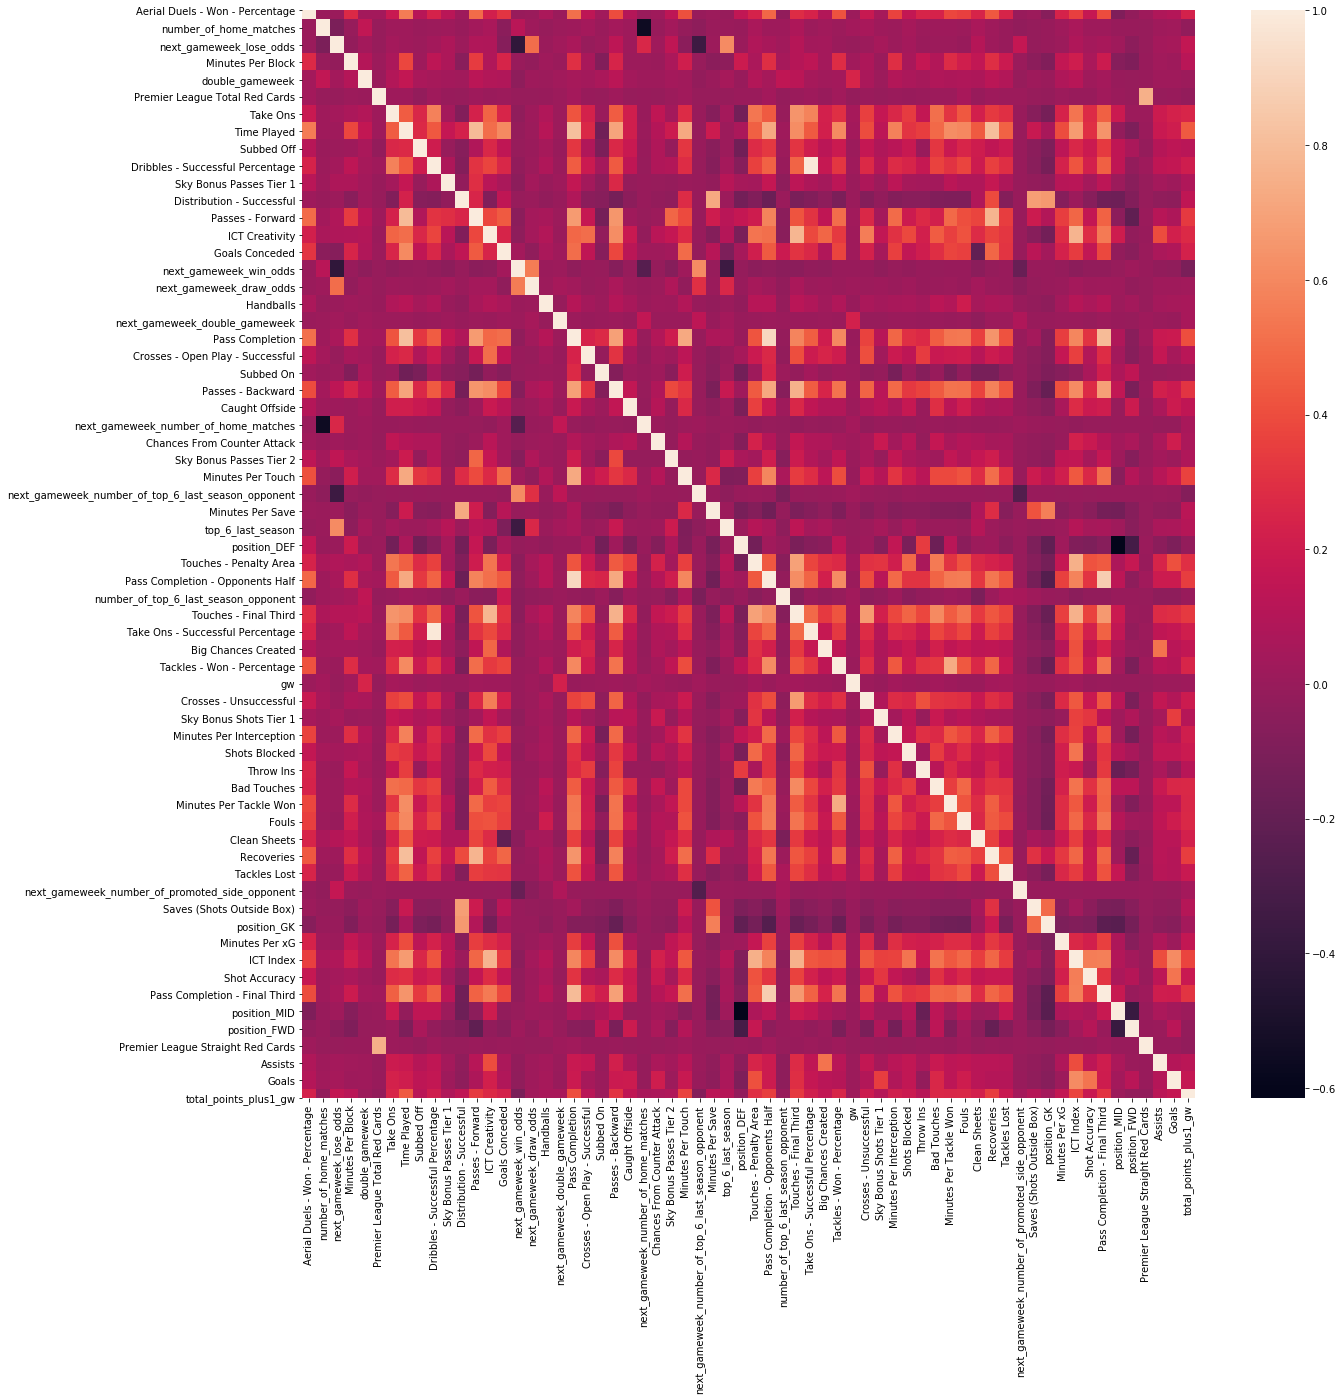

In [51]:
plt.figure(figsize=(20, 20))
sns.heatmap(ffs_data[FINAL_FEATURES + ['total_points_plus1_gw']].corr())
plt.show()

In [52]:
ffs_data[FINAL_FEATURES + ['total_points_plus1_gw']].corr()['total_points_plus1_gw'].sort_values(ascending=False)

total_points_plus1_gw                                 1.000000
Time Played                                           0.439693
Pass Completion                                       0.402928
ICT Index                                             0.370767
Minutes Per Touch                                     0.364753
                                                        ...   
Premier League Total Red Cards                       -0.021326
Premier League Straight Red Cards                    -0.021775
number_of_home_matches                               -0.024188
next_gameweek_number_of_top_6_last_season_opponent   -0.076732
next_gameweek_win_odds                               -0.113926
Name: total_points_plus1_gw, Length: 64, dtype: float64

`Sky Bonus Shots Tier 1` is a scalar of `Shots on Target` (see https://www.fantasyfootballscout.co.uk/2019/08/01/the-changes-to-bonus-points-in-sky-sports-fantasy-football-this-season/)

In [53]:
np.corrcoef(ffs_data['Shots On Target'], ffs_data['Sky Bonus Shots Tier 1'])

array([[1.        , 0.54494526],
       [0.54494526, 1.        ]])

In [54]:
np.corrcoef(ffs_data['Shots'], ffs_data['Sky Bonus Shots Tier 1'])

array([[1.        , 0.39133884],
       [0.39133884, 1.        ]])

To avoid dependency on Sky's transformation of the 'Shots on Target' statistic, which may change in the future, we replace this with `Shots on Target`. As can be seen above this is highly correlated so should be a good proxy.

In [55]:
FINAL_FEATURES.remove('Sky Bonus Shots Tier 1')

In [56]:
FINAL_FEATURES.append('Shots On Target')

Remove other Sky features

In [57]:
FINAL_FEATURES.remove('Sky Bonus Passes Tier 1')
FINAL_FEATURES.remove('Sky Bonus Passes Tier 2')

In [59]:
# Final feature set from previous incorrect run 
OLD_FINAL_FEATURES = {
    'Aerial Duels - Won - Percentage',
    'Assists',
    'Big Chances Created',
    'Caught Offside',
    'Chances Created (Right Zone)',
    'Chances From Counter Attack',
    'Clean Sheets',
    'Crosses - Open Play - Successful',
    'Crosses - Unsuccessful',
    'Distribution - Successful',
    'Distribution - Unsuccessful',
    'Dribbles - Successful Percentage',
    'Goal Kicks',
    'Goals',
    'Goals Conceded',
    'Goals From Penalties',
    'Ground Duels Lost',
    'Handballs',
    'ICT Influence',
    'Minutes Per Save',
    'Minutes Per Touch',
    'Pass Completion',
    'Pass Completion - Final Third',
    'Pass Completion - Opponents Half',
    'Passes - Final Third - Unsuccessful',
    'Passes - Forward - Successful',
    'Passes - Opponents Half - Centre - Unsuccessful',
    'Premier League Straight Red Cards',
    'Premier League Total Red Cards',
    'Recoveries',
    'Saves',
    'Shots - Inside Box',
    'Shots - Long - Attempts',
    'Shots On Target',
    'Subbed Off',
    'Subbed On',
    'Tackles - Won - Percentage',
    'Take Ons',
    'Take Ons - Successful Percentage',
    'Time Played',
    'Touches - Opponents Half - Right',
    'Touches - Penalty Area',
    'double_gameweek',
    'gw',
    'next_gameweek_double_gameweek',
    'next_gameweek_draw_odds',
    'next_gameweek_lose_odds',
    'next_gameweek_number_of_home_matches',
    'next_gameweek_number_of_promoted_side_opponent',
    'next_gameweek_number_of_top_6_last_season_opponent',
    'next_gameweek_win_odds',
    'number_of_home_matches',
    'number_of_top_6_last_season_opponent',
    'position_DEF',
    'position_FWD',
    'position_GK',
    'position_MID',
    'top_6_last_season',
    'xGI Expected Goal Involvement'
}

In [60]:
# New features added compared to last time
set(FINAL_FEATURES) - set(OLD_FINAL_FEATURES)

{'Bad Touches',
 'Fouls',
 'ICT Creativity',
 'ICT Index',
 'Minutes Per Block',
 'Minutes Per Interception',
 'Minutes Per Tackle Won',
 'Minutes Per xG',
 'Passes - Backward',
 'Passes - Forward',
 'Saves (Shots Outside Box)',
 'Shot Accuracy',
 'Shots Blocked',
 'Tackles Lost',
 'Throw Ins',
 'Touches - Final Third'}

In [61]:
# Features no longer in final set
set(OLD_FINAL_FEATURES) - set(FINAL_FEATURES)

{'Chances Created (Right Zone)',
 'Distribution - Unsuccessful',
 'Goal Kicks',
 'Goals From Penalties',
 'Ground Duels Lost',
 'ICT Influence',
 'Passes - Final Third - Unsuccessful',
 'Passes - Forward - Successful',
 'Passes - Opponents Half - Centre - Unsuccessful',
 'Saves',
 'Shots - Inside Box',
 'Shots - Long - Attempts',
 'Touches - Opponents Half - Right',
 'xGI Expected Goal Involvement'}

Add back goals from pens

In [64]:
FINAL_FEATURES.append('Goals From Penalties')

In [62]:
set(FINAL_FEATURES)

{'Aerial Duels - Won - Percentage',
 'Assists',
 'Bad Touches',
 'Big Chances Created',
 'Caught Offside',
 'Chances From Counter Attack',
 'Clean Sheets',
 'Crosses - Open Play - Successful',
 'Crosses - Unsuccessful',
 'Distribution - Successful',
 'Dribbles - Successful Percentage',
 'Fouls',
 'Goals',
 'Goals Conceded',
 'Handballs',
 'ICT Creativity',
 'ICT Index',
 'Minutes Per Block',
 'Minutes Per Interception',
 'Minutes Per Save',
 'Minutes Per Tackle Won',
 'Minutes Per Touch',
 'Minutes Per xG',
 'Pass Completion',
 'Pass Completion - Final Third',
 'Pass Completion - Opponents Half',
 'Passes - Backward',
 'Passes - Forward',
 'Premier League Straight Red Cards',
 'Premier League Total Red Cards',
 'Recoveries',
 'Saves (Shots Outside Box)',
 'Shot Accuracy',
 'Shots Blocked',
 'Shots On Target',
 'Subbed Off',
 'Subbed On',
 'Tackles - Won - Percentage',
 'Tackles Lost',
 'Take Ons',
 'Take Ons - Successful Percentage',
 'Throw Ins',
 'Time Played',
 'Touches - Final Thir

Interesting that total_points not included in feature set.

In [65]:
# Feature with uppercase characters are from football scout. Determines number of tables which need to be scraped.
len([feat for feat in FINAL_FEATURES if any(x.isupper() for x in feat)])

50

Additional features to scrape

In [67]:
# New features added compared to last time
set(FINAL_FEATURES) - set(OLD_FINAL_FEATURES)

{'Bad Touches',
 'Fouls',
 'ICT Creativity',
 'ICT Index',
 'Minutes Per Block',
 'Minutes Per Interception',
 'Minutes Per Tackle Won',
 'Minutes Per xG',
 'Passes - Backward',
 'Passes - Forward',
 'Saves (Shots Outside Box)',
 'Shot Accuracy',
 'Shots Blocked',
 'Tackles Lost',
 'Throw Ins',
 'Touches - Final Third'}